<div>
    <img src="images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
    <span>
        <h1 style="padding-bottom:5px;"> Introduction to Deep Learning </h1>
        <a href="https://masters.em-lyon.com/fr/msc-in-data-science-artificial-intelligence-strategy">[DSAIS]</a> MSc in Data Science & Artificial Intelligence Strategy <br/>
         Paris | © Saeed VARASTEH
    </span>
</div>

## Lecture 06 : PyTorch Image Classification

In this notebook, we'll be working with convolutional neural network architectures in some computer vision tasks.

<img src="./images/FashionCover.png" style="width:18%; "/>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

np.random.seed(72)
torch.manual_seed(72)

---

In [2]:
# Setup device automatically
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device")

Using cuda device


---

### Data

To begin working on a computer vision problem, let's get a computer vision dataset.

We're going to start with __FashionMNIST__ dataset. It contains grayscale images of 10 different kinds of clothing.

Thus, we are going to build a __multiclass classification model__ for grayscale (one channel) images.


<img src="images/fashionMNIST.png" style="width:40%;" />

Here are some PyTorch computer vision libraries you should be aware of.

| PyTorch module | What does it do? |
| :----- | :----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Contains datasets, model architectures and image transformations often used for computer vision problems. |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more.
| [`torchvision.models`](https://pytorch.org/vision/stable/models.html) | This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems. | 
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here. |

<span class="alert-info"> Similar to `torchvision` and `torchvision.datasets`, `torchtext`, and `torchtext.datasets` are two Torch libraries where you can find many example text datasets for a range of natural language processing problems. We will see them later.</span>

#### Getting dataset

In [3]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

To download the FashionMNIST from `torchvision.datasets`, we need to provide the following parameters:

- `root`: str - which folder do you want to download the data to?
- `train`: Bool - do you want the training or test split?
- `download`: Bool - should the data be downloaded?
- `transform`: torchvision.transforms - what transformations would you like to do on the data?
- `target_transform` - you can transform the targets (labels) if you like too.

In [4]:
train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, 
                                  transform=ToTensor(), target_transform=None )

test_dataset = datasets.FashionMNIST(root="data",train=False, download=True, 
                                  transform=ToTensor() )

<div class="alert-info">
    <b>Note</b>: train and test datasets are instances of the <b>Torch Dataset</b> class.
</div>

<div class="alert-warning">
    <b>Note</b>: images come as PIL format, we have to convert them into <b>Torch tensors</b>.
</div>

Let's check out the first sample of the training data.

In [5]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 28, 28])

The shape of the image tensor is [1, 28, 28] or more specifically: `[channels=1, height=28, width=28]`.

Having channels=1 means the image is grayscale.

There's debate on whether images should be represented as CHW (color channels first) or HWC (color channels last).

<div class="alert-info">
    <b>Note</b>: PyTorch generally accepts <b>NCHW (channels first) format</b> as the default for many operators. N stands for number of images.
</div>

Keep it in mind for when you're working on image datasets and using convolutional neural networks.

Let's check out more shapes of our data.

In [6]:
len(train_dataset.data), len(train_dataset.targets), len(test_dataset.data), len(test_dataset.targets)

(60000, 60000, 10000, 10000)

So we've got 60,000 training samples and 10,000 testing samples.

What about the targets?

In [7]:
np.unique( train_dataset.targets )

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

And the classes are:

In [8]:
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

#### Visualize data

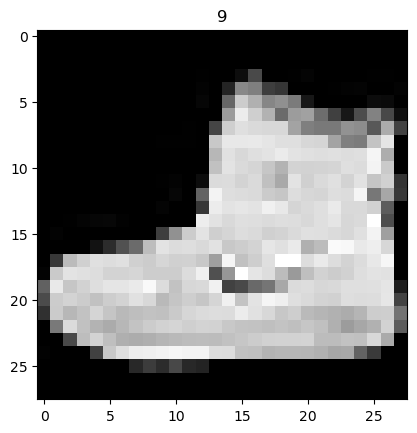

In [9]:
# image shape is [1, 28, 28] (colour channels, height, width)
image, label = train_dataset[0]
plt.imshow(image.squeeze(), cmap="gray") 
plt.title(label);

Let's view a few more.

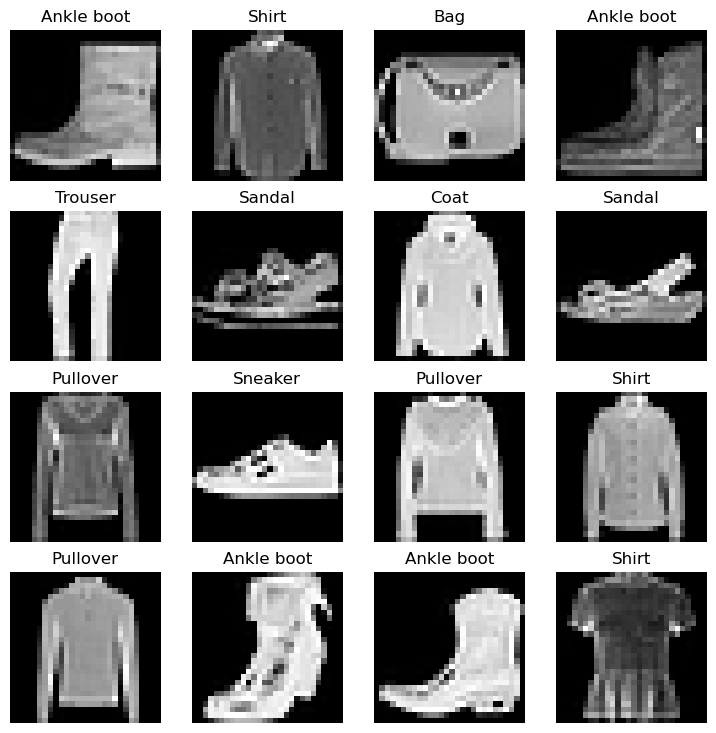

In [10]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

### Train/Validation Split

In [11]:
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000])

len(train_dataset), len(val_dataset)

(50000, 10000)

### DataLoaders

Let's create DataLoader's for our training and test sets.

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)

### Building a Model

Data loaded and prepared! It is time to build a baseline model.

A baseline model is one of the simplest models you can imagine.

Let's use a fully connected with two `nn.Linear()` layers.

We've done this in a previous section but there's going to one slight difference.

Because we're working with image data, we're going to use a different layer to start things off.

And that's the `nn.Flatten()` layer.

In [13]:
import torch.nn.functional as F

class BaseModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.6)

        self.fc1 = None
        self.dropout2 = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, out):
        out = F.relu(self.bn1(self.conv1(out)))
        out = self.pool(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.pool(out)
        out = F.relu(self.bn3(self.conv3(out)))
        out = self.pool(out)

        if self.fc1 is None:
            n_size = out.size()[1] * out.size()[2] * out.size()[3]
            self.fc1 = nn.Linear(n_size, 1024).to(out.device)

        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        return out

Let's bring our accuracy funtion once again:

In [15]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

In [16]:
loss_fn = nn.CrossEntropyLoss()

### Model Training 

Ltes add a timer to the training procedure.

In [17]:
from timeit import default_timer as timer 

In [18]:
from torch.optim.lr_scheduler import StepLR

start_time = timer()  # timer start

model = BaseModel().to(device)

train_losses = []
train_accs = []
validation_losses = []
validation_accs = []

lr = 1e-1
n_epochs = 15
patience = 3 
best_val_loss = float('inf')
patience_counter = 0

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(n_epochs):
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        y_logits = model(x_batch)
        loss = loss_fn(y_logits, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred)
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    model.eval()
    validation_loss, validation_acc = 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_logits = model(x_val)
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred)
    
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)
    validation_acc /= len(val_loader)
    validation_accs.append(validation_acc)
    
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")
    
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    scheduler.step()

end_time = timer()
total_time = end_time - start_time
print(f"Train time on {device}: {total_time:.3f} seconds")


Epoch: 0 | Loss: 0.50631, Accuracy: 82.12% | val loss: 0.36471, val acc: 86.81%
Epoch: 1 | Loss: 0.34896, Accuracy: 87.48% | val loss: 0.29341, val acc: 88.97%
Epoch: 2 | Loss: 0.30292, Accuracy: 89.16% | val loss: 0.29376, val acc: 89.06%
Epoch: 3 | Loss: 0.27782, Accuracy: 90.02% | val loss: 0.25414, val acc: 90.39%
Epoch: 4 | Loss: 0.25582, Accuracy: 90.83% | val loss: 0.24443, val acc: 90.73%
Epoch: 5 | Loss: 0.21210, Accuracy: 92.45% | val loss: 0.21609, val acc: 91.96%
Epoch: 6 | Loss: 0.19873, Accuracy: 92.94% | val loss: 0.21184, val acc: 92.14%
Epoch: 7 | Loss: 0.19125, Accuracy: 93.14% | val loss: 0.21010, val acc: 92.33%
Epoch: 8 | Loss: 0.18433, Accuracy: 93.33% | val loss: 0.20736, val acc: 92.49%
Epoch: 9 | Loss: 0.18054, Accuracy: 93.62% | val loss: 0.20479, val acc: 92.51%
Epoch: 10 | Loss: 0.17399, Accuracy: 93.76% | val loss: 0.20379, val acc: 92.51%
Epoch: 11 | Loss: 0.17328, Accuracy: 93.77% | val loss: 0.20352, val acc: 92.51%
Epoch: 12 | Loss: 0.17270, Accuracy: 9

Learning curves:

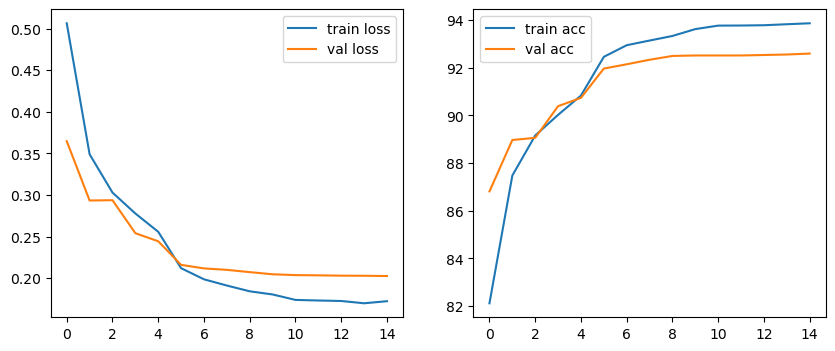

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_losses,  label="train loss"); 
ax[0].plot(validation_losses,  label="val loss"); 
ax[0].legend();

ax[1].plot(train_accs,  label="train acc");
ax[1].plot(validation_accs,  label="val acc"); 
ax[1].legend();

### Making Predications

Let's write some code to evaluate our model.

#### Model accuracy on test data:

We need first to create the test DataLoader.

In [21]:
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [22]:
# Test Loop
model.eval()
test_acc = 0

with torch.no_grad():
    for x_test, y_test in test_loader:

        x_test = x_test.to(device)
        y_test = y_test.to(device)

        y_logits = model(x_test)

        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        test_acc += accuracy_fn(y_true=y_test, y_pred=y_pred)
        
test_acc /= len(test_loader)
print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 92.10%


#### Classification report and Confusion matrix

There are many different evaluation metrics we can use for classification problems.

In [26]:
model.eval()
y_trues = []
y_preds = []

for sample, label in list(test_dataset):

    sample = torch.unsqueeze(sample, dim=0).to(device)

    y_logit = model(sample)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    
    y_preds.append(y_pred.item())
    y_trues.append(label)

print('Done')

Done


In [27]:
from sklearn.metrics import classification_report

print( classification_report(y_trues, y_preds) )

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.84      0.74      0.79      1000
           3       0.90      0.88      0.89      1000
           4       0.72      0.88      0.79      1000
           5       0.99      0.95      0.97      1000
           6       0.74      0.54      0.62      1000
           7       0.92      0.96      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



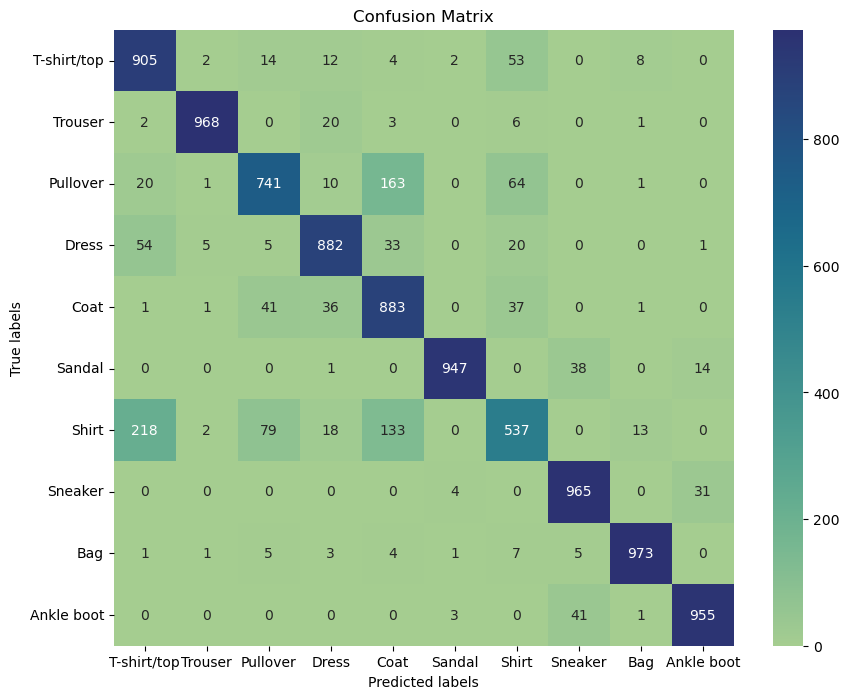

In [28]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="crest");

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); 
ax.yaxis.set_ticklabels(class_names);

plt.yticks(rotation=0);

#### Plot predictions

In [29]:
import random
random.seed(72)

model.eval()
test_samples = []
test_labels = []
y_preds = []

for sample, label in random.sample(list(test_dataset), k=9):
    
    test_samples.append(sample)
    test_labels.append(label)
    
    sample = torch.unsqueeze(sample, dim=0).to(device)

    y_logit = model(sample)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    
    y_preds.append(y_pred.item())

test_labels, y_preds

([0, 4, 3, 3, 2, 4, 0, 0, 9], [0, 4, 0, 3, 2, 4, 0, 0, 9])

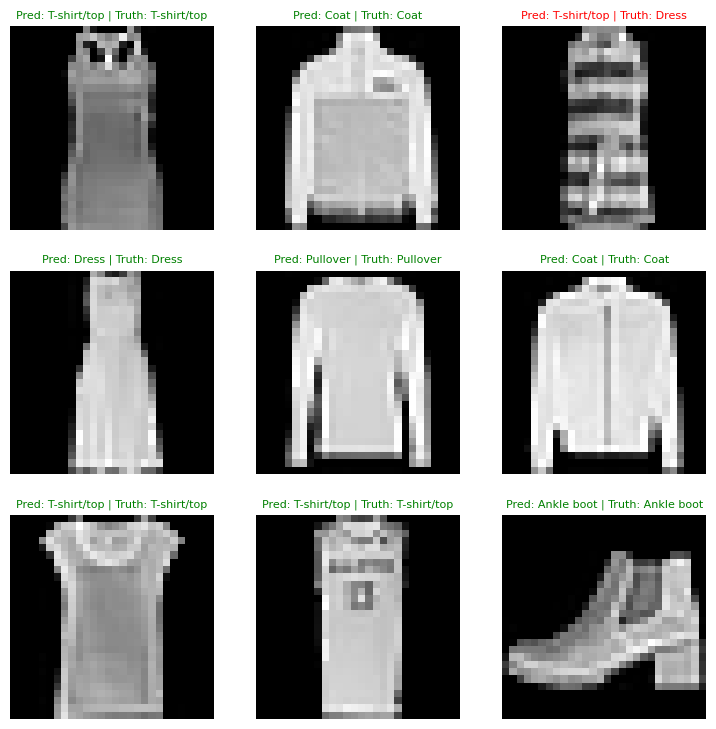

In [30]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    
    pred_label = class_names[y_preds[i]]
    true_label = class_names[test_labels[i]] 
    title_text = f"Pred: {pred_label} | Truth: {true_label}"

    if pred_label == true_label:
        plt.title(title_text, fontsize=8, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=8, c="r") # red text if wrong
        
    plt.axis(False);

---